# Setting Up



In [3]:
!pip install tiingo

In [4]:
!pip install quandl

In [5]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                                # To access websites.

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'349dd4117e5d1ed71a22f0207a8e439cf3f7b06b'})
quandl.ApiConfig.api_key = '_ci7hzC_sPkspKWz2yzt'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')    



In [6]:
#find start of BTC data
GLD= tiingo.get_dataframe(['GLD'],'2008-1-1',metric_name='adjClose')
GLD.index = pd.to_datetime(GLD.index).tz_convert(None)
GLD_ret = GLD.pct_change()
GLD_ret
#BTC start date is 2011-08-19, so that is the first date I will use for the analysis

,GLD
2008-01-02,NaN
2008-01-03,0.008367
2008-01-04,-0.005142
2008-01-07,-0.004229
2008-01-08,0.023711
...,...
2022-03-16,0.006261
2022-03-17,0.004889
2022-03-18,-0.008790
2022-03-21,0.007641


In [7]:
#get ETF prices for SPY and IEF (7-10 year treasuries)
# it doesn't feel right to use 20 year treasuries here because crypto has only been publicly exchanged for around 10 years
PRICE = tiingo.get_dataframe(['ACC','AGG'], '2018-01-01', metric_name='adjClose')
PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)

RET = PRICE.pct_change()
RET[:3]


,ACC,AGG
2018-01-02,NaN,NaN
2018-01-03,-0.016589,0.000092
2018-01-04,-0.017862,-0.000641


<AxesSubplot:>

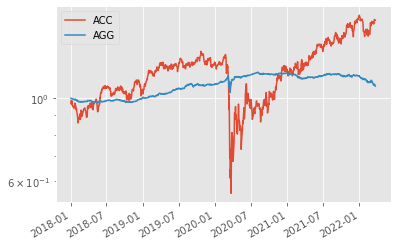

In [8]:
#plot SPY and IEF
RET.add(1).cumprod().plot(logy=True)

,GLD
2008-01-02,NaN
2008-01-03,0.008367
2008-01-04,-0.005142
2008-01-07,-0.004229
2008-01-08,0.023711
...,...
2022-03-16,0.006261
2022-03-17,0.004889
2022-03-18,-0.008790
2022-03-21,0.007641


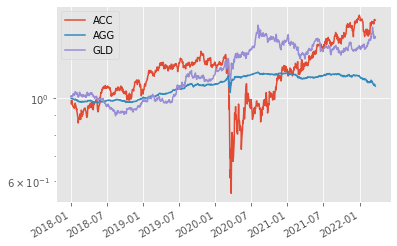

In [9]:
#Add BTC for fun
RET['GLD'] = GLD_ret
RET.add(1).cumprod().plot(logy=True)
GLD_ret

In [10]:
#get fed funds rate and treasury yields
RATES = quandl.get(['FRED/FEDFUNDS','FRED/DGS1','FRED/DGS5','FRED/DGS10','FRED/DGS30']) / 100
RATES.columns = ['FedFunds','Treasury_1', 'Treasury_5', 'Treasury_10', 'Treasury_30']
RATES

,FedFunds,Treasury_1,Treasury_5,Treasury_10,Treasury_30
Date,,,,,
1954-07-01,0.0080,NaN,NaN,NaN,NaN
1954-08-01,0.0122,NaN,NaN,NaN,NaN
1954-09-01,0.0107,NaN,NaN,NaN,NaN
1954-10-01,0.0085,NaN,NaN,NaN,NaN
1954-11-01,0.0083,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-03-07,NaN,0.0107,0.0171,0.0178,0.0219
2022-03-08,NaN,0.0112,0.0180,0.0186,0.0224
2022-03-09,NaN,0.0115,0.0187,0.0194,0.0229


Find Margin Rate (what does this mean? lol)

In [11]:
RET

,ACC,AGG,GLD
2018-01-02,NaN,NaN,0.012131
2018-01-03,-0.016589,0.000092,-0.002637
2018-01-04,-0.017862,-0.000641,0.005127
2018-01-05,0.001263,-0.000642,-0.001036
2018-01-08,0.018416,-0.000275,-0.000160
...,...,...,...
2022-03-16,0.000184,0.000743,0.006261
2022-03-17,0.015789,0.001672,0.004889
2022-03-18,-0.001265,0.002225,-0.008790
2022-03-21,-0.001086,-0.009806,0.007641


For some reason it wouldn't let me add margin rate and then it added like way too many margin rate columns, so I deleted them all and then re-added the margin rate column 

In [12]:

RET = RET.join(RATES.FedFunds.rename('MarginRate'), how='outer')
RET['MarginRate'] = RET.MarginRate.ffill()/252 + 0.01/252           # Assume margin rate = fed funds rate + 100 bsp
RET = RET.dropna(subset=['ACC'])
RET

,ACC,AGG,GLD,MarginRate
2018-01-03,-0.016589,0.000092,-0.002637,0.000096
2018-01-04,-0.017862,-0.000641,0.005127,0.000096
2018-01-05,0.001263,-0.000642,-0.001036,0.000096
2018-01-08,0.018416,-0.000275,-0.000160,0.000096
2018-01-09,-0.016349,-0.002752,-0.004629,0.000096
...,...,...,...,...
2022-03-16,0.000184,0.000743,0.006261,0.000043
2022-03-17,0.015789,0.001672,0.004889,0.000043
2022-03-18,-0.001265,0.002225,-0.008790,0.000043
2022-03-21,-0.001086,-0.009806,0.007641,0.000043


In [13]:
RET.corr()

,ACC,AGG,GLD,MarginRate
ACC,1.000000,0.134420,0.101760,-0.019667
AGG,0.134420,1.000000,0.312019,0.053366
GLD,0.101760,0.312019,1.000000,0.001256
MarginRate,-0.019667,0.053366,0.001256,1.000000


<AxesSubplot:>

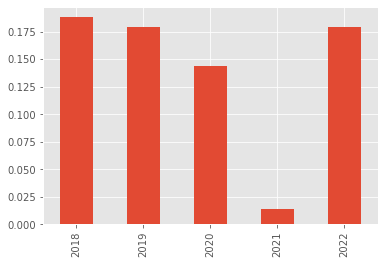

In [14]:
RET[['ACC','AGG']].groupby(RET.index.year).corr().unstack().ACC.AGG.plot.bar()

Let's see what the historical corelation between BTC and the market has looked like. 

<AxesSubplot:>

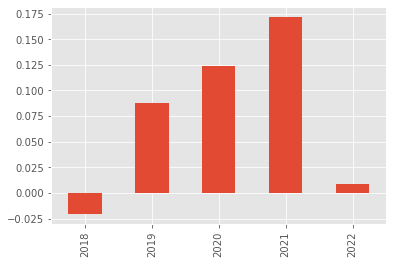

In [15]:
#I'm doing SPY and BTC just to see what the historical correlation has looked like
RET[['ACC','GLD']].groupby(RET.index.year).corr().unstack().ACC.GLD.plot.bar()


It looks like BTC's returns have actually become more correlated with the market over time, which I think checks out. According to the book I read, original demand for BTC was driven by black market activity. But as time went on it became a more popular investment tool for people. And you don't invest in something risky like bitcoin unless you're doing well financially, and more people are doing well when the economy is good. 
-SC

Next we find the annual returns:

In [16]:
r_annual = RET[:'2021'].add(1).resample('A').prod().sub(1)
r_annual

,ACC,AGG,GLD,MarginRate
2018-12-31,0.056895,0.002425,-0.031163,0.028524
2019-12-31,0.182683,0.084556,0.178557,0.032078
2020-12-31,-0.043823,0.074771,0.248146,0.013801
2021-12-31,0.394268,-0.017697,-0.041489,0.010858


Calculating annual excess return (not really sure how this should be done for BTC yet but for now I'll just do it the normal way)

In [17]:
r_annual_Tbill = RATES.Treasury_1.resample('A').first()  # Yield at the beginning of each year
r_annual_Tbill



Date
1954-12-31       NaN
1955-12-31       NaN
1956-12-31       NaN
1957-12-31       NaN
1958-12-31       NaN
               ...  
2018-12-31    0.0183
2019-12-31    0.0260
2020-12-31    0.0156
2021-12-31    0.0010
2022-12-31    0.0040
Freq: A-DEC, Name: Treasury_1, Length: 69, dtype: float64

In [18]:
rx_annual = r_annual.sub(r_annual_Tbill, 'rows').dropna() # Subtract a series from a table with table.sub(series, 'rows')
rx_annual

,ACC,AGG,GLD,MarginRate
2018-12-31,0.038595,-0.015875,-0.049463,0.010224
2019-12-31,0.156683,0.058556,0.152557,0.006078
2020-12-31,-0.059423,0.059171,0.232546,-0.001799
2021-12-31,0.393268,-0.018697,-0.042489,0.009858


# Finding the optimal portfolio of SPY and IEF

First Find their risk premiums:

In [19]:
meanx = rx_annual[['ACC','AGG']].mean()
meanx

ACC    0.132281
AGG    0.020789
dtype: float64

Example Weights:


In [20]:
w = pd.Series({'ACC':0.6, 'AGG':0.4})
w

ACC    0.6
AGG    0.4
dtype: float64

Calculate portfolio risk premium:

$$
\text{portfolio risk premium}
\hspace{1em}=\hspace{1em}
\mathbf{w}\cdot E[\mathbf{r}^x]
\hspace{1em}=\hspace{1em}
\underbrace{\begin{bmatrix}0.7&0.3\end{bmatrix} \times \begin{bmatrix}0.100888\\0.064561\end{bmatrix}}_\text{"dot product"}
\hspace{1em}=\hspace{1em}
\underbrace{0.7 \times 0.100888 + 0.3 \times 0.064561}_\text{weighted average}
$$

In [21]:
(w * meanx).sum()        # weighted average of individual risk premiums

0.08768391535539022

The portfolio variance is the dot product between the portfolio weights and the covariance matrix:

$$
\text{portfolio variance } =  \text{weights }\times\text{ covariance matrix }\times\text{ weights}
$$

Implement this:

In [22]:
# Covariance matrix:
cov = RET[['ACC','AGG']].cov() * 252      # multiply by 252 to annualize the covariance
cov

,ACC,AGG
ACC,0.128068,0.002461
AGG,0.002461,0.002617


In [23]:
w.dot(cov).dot(w)**0.5

0.21841365704685353

In [24]:
t = pd.DataFrame(index=range(11))

for i in t.index:
    w                       = pd.Series({'ACC':i/10, 'AGG':1-i/10})
    t.loc[i,'ACC']          = w.ACC
    t.loc[i,'AGG']          = w.AGG
    t.loc[i,'Risk_premium'] = w.dot(meanx)
    t.loc[i,'Volatility']   = w.dot(cov).dot(w) ** 0.5

t['Sharpe'] = t.Risk_premium / t.Volatility        
t

,ACC,AGG,Risk_premium,Volatility,Sharpe
0,0.0,1.0,0.020789,0.051157,0.406378
1,0.1,0.9,0.031938,0.061995,0.515170
2,0.2,0.8,0.043087,0.087092,0.494730
3,0.3,0.7,0.054236,0.117652,0.460989
4,0.4,0.6,0.065386,0.150380,0.434801
5,0.5,0.5,0.076535,0.184124,0.415669
6,0.6,0.4,0.087684,0.218414,0.401458
7,0.7,0.3,0.098833,0.253027,0.390603
8,0.8,0.2,0.109982,0.287847,0.382086
9,0.9,0.1,0.121131,0.322807,0.375244


<AxesSubplot:xlabel='Volatility', ylabel='Risk_premium'>

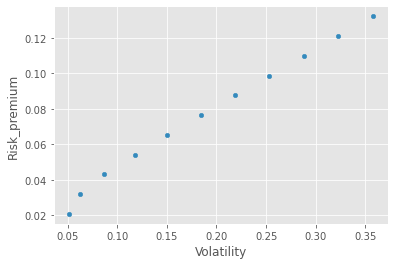

In [25]:
t.plot.scatter('Volatility','Risk_premium')

<AxesSubplot:xlabel='Volatility', ylabel='Risk_premium'>

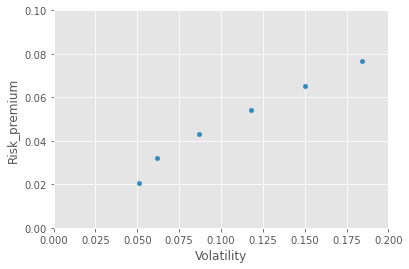

In [26]:
t.plot.scatter('Volatility','Risk_premium', ylim=(0,0.1), xlim=(0,0.2))

Maximum Sharpe ratio weights:

$$
\mathbf{w} = \frac{\mathbf{\Sigma}^{-1}E[\mathbf{r}^x]}{\text{Sum}\big(\mathbf{\Sigma}^{-1}E[\mathbf{r}^x]\big)}
$$

($\Sigma=$ covariance matrix).    

Calculate the inverse of the covariance matrix:



In [27]:
cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
cov_inv


,ACC,AGG
ACC,7.952016,-7.477570
AGG,-7.477570,389.148064


In [28]:
w_maxSharpe = cov_inv.dot(meanx) /  cov_inv.dot(meanx).sum()
w_maxSharpe

ACC    0.112094
AGG    0.887906
dtype: float64

Minimum volatility portfolio weights:

$$
\mathbf{w_{minvol}}
= \frac{\mathbf{\Sigma}^{-1}\mathbf{1}}{\text{Sum}\big(\mathbf{\Sigma}^{-1}\mathbf{1}\big)}
$$

where $\mathbf{1}$ is a vector of ones and $\mathbf{\Sigma}^{-1}\mathbf{1}$ is row or column sum of the inverse covariance matrix.

Implement this:

In [29]:
w_minVol = cov_inv.sum() / cov_inv.sum().sum()
w_minVol

ACC    0.001242
AGG    0.998758
dtype: float64

<AxesSubplot:>

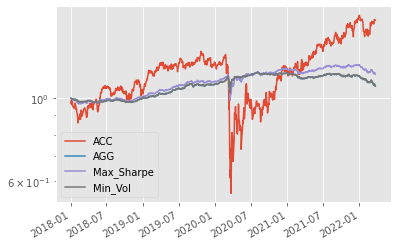

In [30]:
t = pd.DataFrame()
t['ACC']        = RET.ACC
t['AGG']        = RET.AGG
t['Max_Sharpe'] = RET.multiply(w_maxSharpe).sum('columns')
t['Min_Vol']    = RET.multiply(w_minVol).sum('columns')

t.add(1).cumprod().plot(logy=True)

In [31]:
t

,ACC,AGG,Max_Sharpe,Min_Vol
2018-01-03,-0.016589,0.000092,-0.001778,0.000071
2018-01-04,-0.017862,-0.000641,-0.002571,-0.000663
2018-01-05,0.001263,-0.000642,-0.000428,-0.000639
2018-01-08,0.018416,-0.000275,0.001820,-0.000252
2018-01-09,-0.016349,-0.002752,-0.004276,-0.002769
...,...,...,...,...
2022-03-16,0.000184,0.000743,0.000681,0.000743
2022-03-17,0.015789,0.001672,0.003254,0.001689
2022-03-18,-0.001265,0.002225,0.001834,0.002221
2022-03-21,-0.001086,-0.009806,-0.008828,-0.009795


# Adding Gold to the portfolio
I think that the best way to do this is to treat the portfolio with crypto as if it only has two elements: 
1. The portfolio we just made with SPY and IEF
2. Crypto

In other words, we just treat the base portfolio as if it is one security, and as if we are investing in that security and a varying amount of crypto. I think we did something like this in valuation or last year's investment class, where we started with a base portfolio and invested in that portfolio and varying weights of bonds. Doing it this way will make it easier to find the optimized weights with crypto involved. 

## Starting with the Max Sharpe Portfolio
Find the risk premium of the portfolio:

In [32]:
t['GLD'] = GLD_ret
t

,ACC,AGG,Max_Sharpe,Min_Vol,GLD
2018-01-03,-0.016589,0.000092,-0.001778,0.000071,-0.002637
2018-01-04,-0.017862,-0.000641,-0.002571,-0.000663,0.005127
2018-01-05,0.001263,-0.000642,-0.000428,-0.000639,-0.001036
2018-01-08,0.018416,-0.000275,0.001820,-0.000252,-0.000160
2018-01-09,-0.016349,-0.002752,-0.004276,-0.002769,-0.004629
...,...,...,...,...,...
2022-03-16,0.000184,0.000743,0.000681,0.000743,0.006261
2022-03-17,0.015789,0.001672,0.003254,0.001689,0.004889
2022-03-18,-0.001265,0.002225,0.001834,0.002221,-0.008790
2022-03-21,-0.001086,-0.009806,-0.008828,-0.009795,0.007641


In [33]:
max_r_annual = t[:'2021'].add(1).resample('A').prod().sub(1)
max_r_annual

,ACC,AGG,Max_Sharpe,Min_Vol,GLD
2018-12-31,0.056895,0.002425,0.010311,0.002515,-0.031163
2019-12-31,0.182683,0.084556,0.096382,0.084688,0.178557
2020-12-31,-0.043823,0.074771,0.084210,0.074905,0.248146
2021-12-31,0.394268,-0.017697,0.024084,-0.017240,-0.041489


In [34]:
max_rx_annual = max_r_annual.sub(r_annual_Tbill, 'rows').dropna() # Subtract a series from a table with table.sub(series, 'rows')
max_rx_annual

,ACC,AGG,Max_Sharpe,Min_Vol,GLD
2018-12-31,0.038595,-0.015875,-0.007989,-0.015785,-0.049463
2019-12-31,0.156683,0.058556,0.070382,0.058688,0.152557
2020-12-31,-0.059423,0.059171,0.068610,0.059305,0.232546
2021-12-31,0.393268,-0.018697,0.023084,-0.018240,-0.042489


In [35]:
max_meanx = max_rx_annual[['Max_Sharpe','GLD']].mean()
max_meanx

Max_Sharpe    0.038522
GLD           0.073288
dtype: float64

Obviously, using the annual mean rx for bitcoin isn't going to work here. Using the Median might help here, because it is a metric less sensitive to outliers. I don't know if this is valid to do for the linear algebra though.


In [36]:
max_medx = max_rx_annual[['Max_Sharpe','GLD']].median()
max_medx

Max_Sharpe    0.045847
GLD           0.055034
dtype: float64

Now, set the example weights:

In [37]:
max_w = pd.Series({'Max_Sharpe':0.6,'GLD':0.4})
max_w

Max_Sharpe    0.6
GLD           0.4
dtype: float64

Calculate portfolio risk premium:


In [38]:
(max_w * max_meanx).sum()

0.052428100279738474

Now find portfolio variance:

In [39]:
max_cov = t[['Max_Sharpe','GLD']].cov()*252
max_cov

,Max_Sharpe,GLD
Max_Sharpe,0.004162,0.002602
GLD,0.002602,0.020322


Volatility:

In [40]:
max_w.dot(max_cov).dot(max_w) ** 0.5 

0.07745362557135471

In [41]:
m = pd.DataFrame(index=range(11))

for i in m.index:
    w                       = pd.Series({'Max_Sharpe':i/10, 'GLD':1-i/10})
    m.loc[i,'Max_Sharpe']   = w.Max_Sharpe
    m.loc[i,'GLD']          = w.GLD
    m.loc[i,'Risk_premium'] = w.dot(max_meanx)
    m.loc[i,'Volatility']   = w.dot(max_cov).dot(w) ** 0.5

m['Sharpe'] = m.Risk_premium / m.Volatility        
m

,Max_Sharpe,GLD,Risk_premium,Volatility,Sharpe
0,0.0,1.0,0.073288,0.142556,0.514097
1,0.1,0.9,0.069811,0.130273,0.535883
2,0.2,0.8,0.066334,0.118345,0.560520
3,0.3,0.7,0.062858,0.106890,0.588062
4,0.4,0.6,0.059381,0.096078,0.618050
5,0.5,0.5,0.055905,0.086153,0.648903
6,0.6,0.4,0.052428,0.077454,0.676897
7,0.7,0.3,0.048952,0.070438,0.694963
8,0.8,0.2,0.045475,0.065646,0.692725
9,0.9,0.1,0.041998,0.063585,0.660508


<AxesSubplot:xlabel='Volatility', ylabel='Risk_premium'>

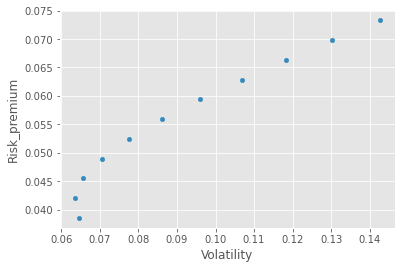

In [42]:
m.plot.scatter('Volatility','Risk_premium')

The covariance between BTC and the market is so low that the efficient frontier looks like basically a straight line

Now find the maximum sharpe ratio of this new portfolio blend:

In [43]:
np.linalg.inv(max_cov)

array([[261.16564465, -33.44299542],
       [-33.44299542,  53.48972652]])

In [44]:
max_cov_inv = pd.DataFrame(np.linalg.inv(max_cov), columns=max_cov.columns, index=max_cov.index)
max_cov_inv

,Max_Sharpe,GLD
Max_Sharpe,261.165645,-33.442995
GLD,-33.442995,53.489727


Maximum Sharpe Ratio Weights:

In [45]:
max_w_maxSharpe = max_cov_inv.dot(max_medx) /  max_cov_inv.dot(max_medx).sum()
max_w_maxSharpe

Max_Sharpe    0.877813
GLD           0.122187
dtype: float64

Unsurprisingly, the max sharpe ratio for this portfolio blend is mostly the base portfolio.

Now let's find the minimum volatility weights for this portfolio:

In [46]:
max_w_minVol = max_cov_inv.sum() / max_cov_inv.sum().sum()
max_w_minVol

Max_Sharpe    0.919091
GLD           0.080909
dtype: float64

The minimum volatility portfolio actually suggests that one shold not short gold, unlike BTC.

Now let's compound the returns of these optimal portfolios, based on a blend of GLD and our maximum sharpe ratio base portfolio.

,Base_Max_Sharpe,GLD,GLD_Max_Sharpe,GLD_Min_Vol
2018-01-03,-0.001694,-0.002637,-0.001809,-0.001765
2018-01-04,-0.002485,0.005127,-0.001554,-0.001913
2018-01-05,-0.000438,-0.001036,-0.000511,-0.000483
2018-01-08,0.001726,-0.000160,0.001495,0.001584
2018-01-09,-0.004208,-0.004629,-0.004259,-0.004239
...,...,...,...,...
2022-02-22,-0.001712,0.002089,-0.001248,-0.001427
2022-02-23,-0.002608,0.004507,-0.001739,-0.002075
2022-02-24,0.004231,-0.006450,0.002925,0.003429
2022-02-25,0.004720,-0.003331,0.003736,0.004116


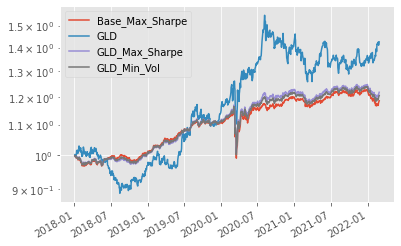

In [63]:
l = pd.DataFrame()
l['Base_Max_Sharpe'] = t.Max_Sharpe
l['GLD']             = t.GLD
l['GLD_Max_Sharpe']  = t.multiply(max_w_maxSharpe).sum('columns')
l['GLD_Min_Vol']     = t.multiply(max_w_minVol).sum('columns')

l.add(1).cumprod().plot(logy=True)
l

## Adding Gold to the minimum volatility portfolio
Find the risk premium of the portfolio:

In [2]:
t['GLD'] = GLD_ret
t

NameError: name 'GLD_ret' is not defined

In [50]:
min_r_annual = t[:'2021'].add(1).resample('A').prod().sub(1)
min_r_annual

,ACC,AGG,Max_Sharpe,Min_Vol,BTC
2018-12-31,0.056895,0.002425,0.009965,0.002446,-0.739754
2019-12-31,0.182683,0.084556,0.095853,0.084586,0.646581
2020-12-31,-0.043823,0.074771,0.083903,0.074801,3.807329
2021-12-31,0.394268,-0.017697,0.022178,-0.017593,0.234006


In [51]:
min_rx_annual = min_r_annual.sub(r_annual_Tbill, 'rows').dropna() # Subtract a series from a table with table.sub(series, 'rows')
min_rx_annual

,ACC,AGG,Max_Sharpe,Min_Vol,BTC
2018-12-31,0.038595,-0.015875,-0.008335,-0.015854,-0.758054
2019-12-31,0.156683,0.058556,0.069853,0.058586,0.620581
2020-12-31,-0.059423,0.059171,0.068303,0.059201,3.791729
2021-12-31,0.393268,-0.018697,0.021178,-0.018593,0.233006


In [60]:
min_meanx = min_rx_annual[['Min_Vol','BTC']].mean()
min_meanx

Min_Vol    0.020835
BTC        0.971816
dtype: float64

Obviously, using the annual mean rx for bitcoin isn't going to work here. Using the Median might help here, because it is a metric less sensitive to outliers. I don't know if this is valid to do for the linear algebra though.


In [61]:
min_medx = max_rx_annual[['Min_Vol','BTC']].median()
min_medx

Min_Vol    0.021366
BTC        0.426794
dtype: float64

Now, set the example weights:

In [62]:
min_w = pd.Series({'Min_Vol':0.6,'BTC':0.4})
min_w

Min_Vol    0.6
BTC        0.4
dtype: float64

Calculate portfolio risk premium:


In [64]:
(min_w * min_medx).sum()

0.1835371462267434

Now find portfolio variance:

In [63]:
min_cov = t[['Min_Vol','BTC']].cov()*252
min_cov

,Min_Vol,BTC
Min_Vol,0.002536,0.005293
BTC,0.005293,0.481342


Volatility:

In [65]:
min_w.dot(min_cov).dot(min_w) ** 0.5 

0.28366962344681007

In [66]:
m = pd.DataFrame(index=range(11))

for i in m.index:
    w                       = pd.Series({'Min_Vol':i/10, 'BTC':1-i/10})
    m.loc[i,'Min_Vol']      = w.Min_Vol
    m.loc[i,'BTC']          = w.BTC
    m.loc[i,'Risk_premium'] = w.dot(min_medx)
    m.loc[i,'Volatility']   = w.dot(min_cov).dot(w) ** 0.5

m['Sharpe'] = m.Risk_premium / m.Volatility        
m

,Min_Vol,BTC,Risk_premium,Volatility,Sharpe
0,0.0,1.0,0.426794,0.693788,0.615164
1,0.1,0.9,0.386251,0.625192,0.617812
2,0.2,0.8,0.345708,0.556645,0.621056
3,0.3,0.7,0.305165,0.488169,0.625122
4,0.4,0.6,0.264623,0.419797,0.630358
5,0.5,0.5,0.224080,0.351591,0.637331
6,0.6,0.4,0.183537,0.283670,0.647010
7,0.7,0.3,0.142994,0.216302,0.661086
8,0.8,0.2,0.102452,0.150235,0.681942
9,0.9,0.1,0.061909,0.088433,0.700064


<AxesSubplot:xlabel='Volatility', ylabel='Risk_premium'>

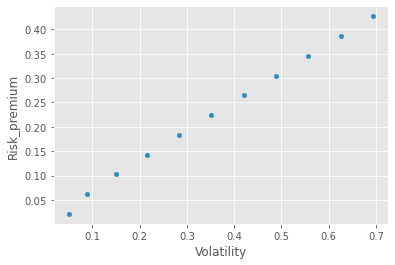

In [67]:
m.plot.scatter('Volatility','Risk_premium')

The covariance between BTC and the market is so low that the efficient frontier looks like basically a straight line

Now find the maximum sharpe ratio of this new portfolio blend:

In [69]:
np.linalg.inv(min_cov)

array([[403.57101585,  -4.43798956],
       [ -4.43798956,   2.12632866]])

In [70]:
min_cov_inv = pd.DataFrame(np.linalg.inv(min_cov), columns=min_cov.columns, index=min_cov.index)
min_cov_inv

,Min_Vol,BTC
Min_Vol,403.571016,-4.437990
BTC,-4.437990,2.126329


Maximum Sharpe Ratio Weights:

In [71]:
min_w_maxSharpe = min_cov_inv.dot(min_medx) /  min_cov_inv.dot(min_medx).sum()
min_w_maxSharpe

Min_Vol    0.892236
BTC        0.107764
dtype: float64

Unsurprisingly, the max sharpe ratio for this portfolio blend is mostly the base portfolio.

Now let's find the minimum volatility weights for this portfolio:

In [72]:
min_w_minVol = min_cov_inv.sum() / min_cov_inv.sum().sum()
min_w_minVol

Min_Vol    1.005825
BTC       -0.005825
dtype: float64

The minimum volatility portfolio actually suggests that one shold ***short*** bitcoin.

Now let's compound the returns of these optimal portfolios, based on a blend of BTC and our maximum sharpe ratio base portfolio.

,Base_Min_Vol,BTC,BTC_Max_Sharpe,BTC_Min_Vol
2018-01-03,0.000087,0.091906,0.009982,-0.000448
2018-01-04,-0.000646,0.032474,0.002923,-0.000839
2018-01-05,-0.000641,-0.000788,-0.000657,-0.000640
2018-01-08,-0.000270,-0.059806,-0.006686,0.000077
2018-01-09,-0.002756,-0.069712,-0.009971,-0.002366
...,...,...,...,...
2022-02-22,-0.001094,0.033086,0.002590,-0.001293
2022-02-23,-0.004460,-0.025701,-0.006749,-0.004336
2022-02-24,0.001837,0.029026,0.004767,0.001678
2022-02-25,0.001015,0.023104,0.003395,0.000886


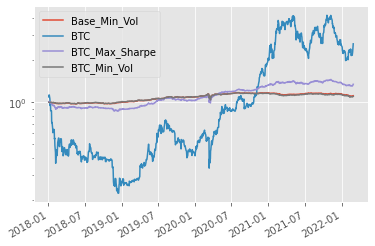

In [73]:
l = pd.DataFrame()
l['Base_Min_Vol'] = t.Min_Vol
l['BTC']             = t.BTC
l['BTC_Max_Sharpe']  = t.multiply(min_w_maxSharpe).sum('columns')
l['BTC_Min_Vol']     = t.multiply(min_w_minVol).sum('columns')

l.add(1).cumprod().plot(logy=True)
l

In [1]:
## Adding Crypto to the minimum volatility portfolio
Find the risk premium of the portfolio:

t['BTC'] = BTC_ret
t

min_r_annual = t[:'2021'].add(1).resample('A').prod().sub(1)
min_r_annual

min_rx_annual = min_r_annual.sub(r_annual_Tbill, 'rows').dropna() # Subtract a series from a table with table.sub(series, 'rows')
min_rx_annual

min_meanx = min_rx_annual[['Min_Vol','BTC']].mean()
min_meanx

Obviously, using the annual mean rx for bitcoin isn't going to work here. Using the Median might help here, because it is a metric less sensitive to outliers. I don't know if this is valid to do for the linear algebra though.


min_medx = max_rx_annual[['Min_Vol','BTC']].median()
min_medx

Now, set the example weights:

min_w = pd.Series({'Min_Vol':0.6,'BTC':0.4})
min_w

Calculate portfolio risk premium:


(min_w * min_medx).sum()

Now find portfolio variance:

min_cov = t[['Min_Vol','BTC']].cov()*252
min_cov

Volatility:

min_w.dot(min_cov).dot(min_w) ** 0.5 

m = pd.DataFrame(index=range(11))

for i in m.index:
    w                       = pd.Series({'Min_Vol':i/10, 'BTC':1-i/10})
    m.loc[i,'Min_Vol']      = w.Min_Vol
    m.loc[i,'BTC']          = w.BTC
    m.loc[i,'Risk_premium'] = w.dot(min_medx)
    m.loc[i,'Volatility']   = w.dot(min_cov).dot(w) ** 0.5

m['Sharpe'] = m.Risk_premium / m.Volatility        
m

m.plot.scatter('Volatility','Risk_premium')

The covariance between BTC and the market is so low that the efficient frontier looks like basically a straight line

Now find the maximum sharpe ratio of this new portfolio blend:

np.linalg.inv(min_cov)

min_cov_inv = pd.DataFrame(np.linalg.inv(min_cov), columns=min_cov.columns, index=min_cov.index)
min_cov_inv

Maximum Sharpe Ratio Weights:

min_w_maxSharpe = min_cov_inv.dot(min_medx) /  min_cov_inv.dot(min_medx).sum()
min_w_maxSharpe

Unsurprisingly, the max sharpe ratio for this portfolio blend is mostly the base portfolio.

Now let's find the minimum volatility weights for this portfolio:

min_w_minVol = min_cov_inv.sum() / min_cov_inv.sum().sum()
min_w_minVol

The minimum volatility portfolio actually suggests that one shold ***short*** bitcoin.

Now let's compound the returns of these optimal portfolios, based on a blend of BTC and our maximum sharpe ratio base portfolio.

l = pd.DataFrame()
l['Base_Min_Vol'] = t.Min_Vol
l['BTC']             = t.BTC
l['BTC_Max_Sharpe']  = t.multiply(min_w_maxSharpe).sum('columns')
l['BTC_Min_Vol']     = t.multiply(min_w_minVol).sum('columns')

l.add(1).cumprod().plot(logy=True)
l

SyntaxError: invalid syntax (<ipython-input-1-0c036c85cdfc>, line 2)